In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
class_labels = {
    'on': 0,
    'off': 1,
    'left': 2,
    'right': 3,
    'up': 4,
    'down': 5,
    'zero': 6,
    'one': 7,
    'two': 8,
    'three': 9,
    'four': 10,
    'five': 11,
    'six': 12,
    'seven': 13,
    'eight': 14,
    'nine': 15,
    'other': 16
}

In [4]:
TRAINING_EPOCHS = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 1

In [5]:
train_X = np.load('training-features.npy')
train_Y = np.load('training-labels.npy')

dev_X = np.load('dev-features.npy')
dev_Y = np.load('dev-labels.npy')

test_X = np.load('test-features.npy')
test_Y = np.load('test-labels.npy')

In [6]:
train_X.shape

(41849, 20, 44)

In [7]:
train_Y.shape

(41849, 17)

In [8]:
def plot_confusion_matrix(matrix, class_name):
    tn, fp, fn, tp = matrix.flatten()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f'Precision for {class_name}: {precision}')
    print(f'Recall for {class_name}: {recall}')
    print(f'F1 score for {class_name}: {f1_score}')
    
    names = ['True Negative','False Positive','False Negative','True Positive']
    counts = ['{0:0.0f}'.format(val) for val in matrix.flatten()]
    percents = ['{0:.2%}'.format(val) for val in matrix.flatten() / np.sum(matrix)]
    labels_list = [f'{name}\n{count}\n{percentage}' for name, count, percentage in zip(names, counts, percents)]
    labels = np.asarray(labels_list).reshape(2, 2)
    ax = plt.axes()
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Reds')
    ax.set_title(class_name)
    plt.show()

In [9]:
def model():
    
    X_input = tf.keras.layers.Input(shape=(20,44))
    X = tf.keras.layers.LayerNormalization() (X_input)
    X = tf.keras.layers.GRU(units=44, activation='relu', dropout=0.3, return_sequences=True) (X)
    X = tf.keras.layers.Flatten() (X)
    X = tf.keras.layers.BatchNormalization() (X)
    X = tf.keras.layers.Dense(32, activation='sigmoid') (X)
    X = tf.keras.layers.Dense(17, activation='softmax') (X)
    
    model = tf.keras.Model(inputs=X_input, outputs=X, name='RELU_GRU_SIGMOID')
    
    return model

In [10]:
model = model()

In [11]:
model.summary()

Model: "RELU_GRU_SIGMOID"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 44)]          0         
_________________________________________________________________
layer_normalization (LayerNo (None, 20, 44)            88        
_________________________________________________________________
gru (GRU)                    (None, 20, 44)            11880     
_________________________________________________________________
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 880)               3520      
_________________________________________________________________
dense (Dense)                (None, 32)                28192     
_________________________________________________________________
dense_1 (Dense)              (None, 17)           

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tfa.metrics.MultiLabelConfusionMatrix(name='Confusion matrix', num_classes=17),
]
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

In [13]:
history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=TRAINING_EPOCHS, shuffle=True)

 3733/41849 [=>............................] - ETA: 5:03 - loss: 2.5798 - Accuracy: 0.3054 - Confusion matrix: 466.7500

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

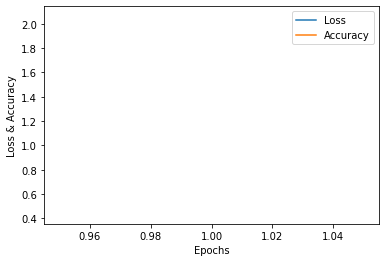

In [14]:
loss = history.history['loss']
accuracy = history.history['Accuracy']
epochs = range(1, TRAINING_EPOCHS+1)

plt.plot(epochs, loss, label="Loss")
plt.plot(epochs, accuracy, label="Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss & Accuracy')
plt.legend()

plt.show

In [15]:
training_confusion_matrix = history.history['Confusion matrix']

<ipython-input-8-f6d39b89d5b8>:3: RuntimeWarning: invalid value encountered in float_scalars
  precision = tp / (tp + fp)


Precision for on: nan
Recall for on: 0.0
F1 score for on: nan


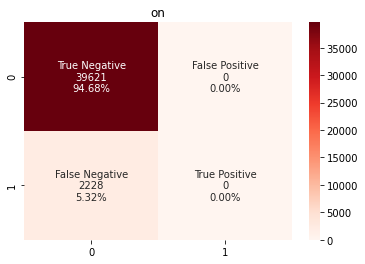

Precision for off: nan
Recall for off: 0.0
F1 score for off: nan


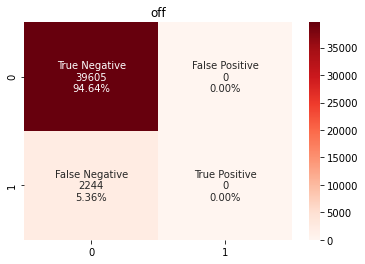

Precision for left: nan
Recall for left: 0.0
F1 score for left: nan


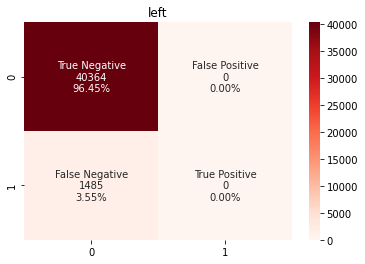

Precision for right: nan
Recall for right: 0.0
F1 score for right: nan


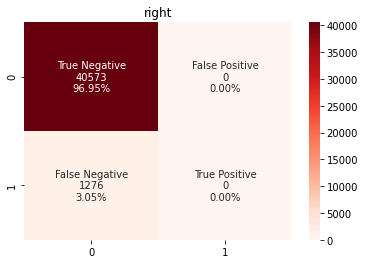

Precision for up: nan
Recall for up: 0.0
F1 score for up: nan


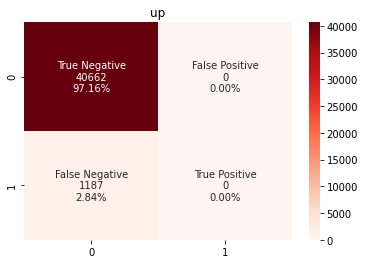

Precision for down: nan
Recall for down: 0.0
F1 score for down: nan


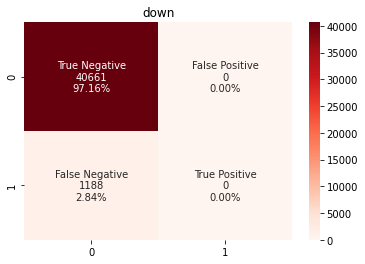

Precision for zero: nan
Recall for zero: 0.0
F1 score for zero: nan


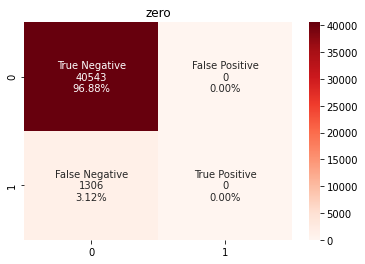

Precision for one: nan
Recall for one: 0.0
F1 score for one: nan


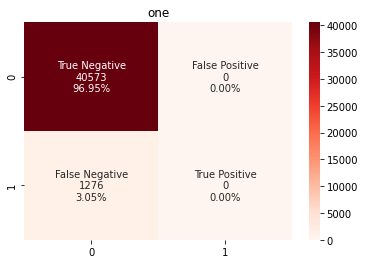

Precision for two: nan
Recall for two: 0.0
F1 score for two: nan


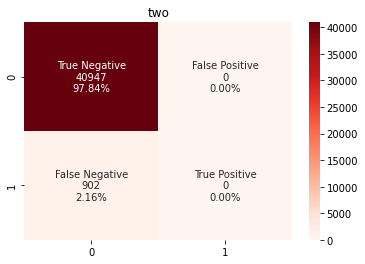

Precision for three: nan
Recall for three: 0.0
F1 score for three: nan


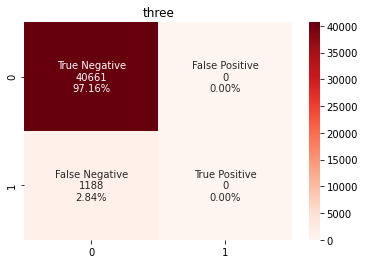

Precision for four: nan
Recall for four: 0.0
F1 score for four: nan


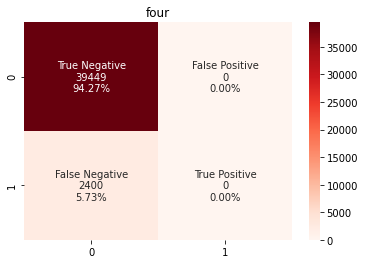

Precision for five: nan
Recall for five: 0.0
F1 score for five: nan


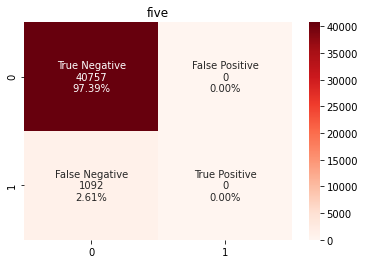

Precision for six: nan
Recall for six: 0.0
F1 score for six: nan


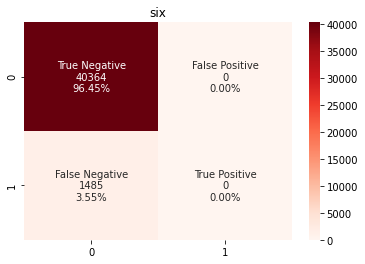

Precision for seven: nan
Recall for seven: 0.0
F1 score for seven: nan


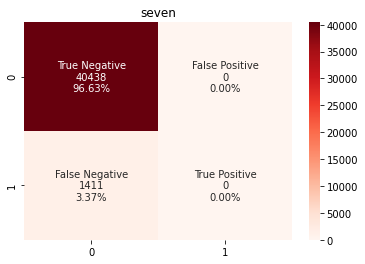

Precision for eight: nan
Recall for eight: 0.0
F1 score for eight: nan


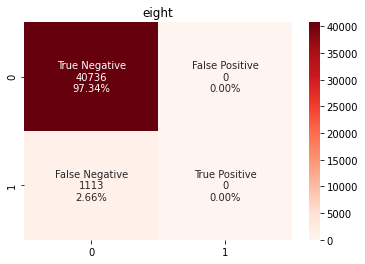

Precision for nine: nan
Recall for nine: 0.0
F1 score for nine: nan


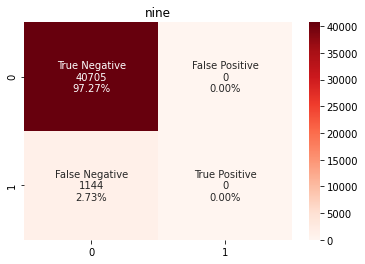

Precision for other: nan
Recall for other: 0.0
F1 score for other: nan


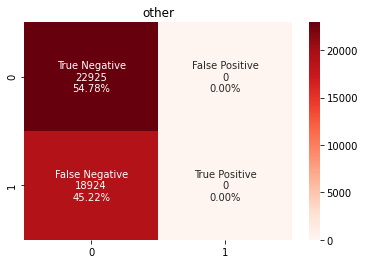

In [16]:
last_train_confusion_matrix = training_confusion_matrix[-1]
for class_name in class_labels:
    class_index = class_labels[class_name]
    plot_confusion_matrix(last_train_confusion_matrix[class_index], class_name)

In [19]:
dev_loss, dev_accuracy, dev_confusion_matrix = model.evaluate(dev_X, dev_Y, verbose=2)

654/654 - 3s - loss: 0.1126 - Accuracy: 0.9672 - Confusion matrix: 5230.5000 - Precision: 0.9746 - Recall: 0.9627 - F1 score: 0.9607 - True positives: 20141.0000 - False positives: 525.0000 - True negatives: 334227.0000 - False negatives: 781.0000


ValueError: too many values to unpack (expected 3)

In [20]:
for class_name in class_labels:
    class_index = class_labels[class_name]
    plot_confusion_matrix(dev_confusion_matrix[class_index], class_name)

NameError: name 'dev_confusion_matrix' is not defined